<a href="https://colab.research.google.com/github/saxenaaayush/image-classifier/blob/main/notebooks/01PreProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

REPO_DIR = "/content/drive/MyDrive/image-classifier"
%cd $REPO_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/image-classifier


In [62]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from collections import Counter
from tqdm import tqdm
import numpy as np
import hashlib
import shutil

In [13]:
base_dir = "data/raw/processed_images"


train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")


train_cataract_dir = os.path.join(train_dir, "cataract")
train_normal_dir   = os.path.join(train_dir, "normal")

test_cataract_dir = os.path.join(test_dir, "cataract")
test_normal_dir   = os.path.join(test_dir, "normal")

In [14]:
print("TRAINING SET")
print("# of Cataract images:", len(os.listdir(train_cataract_dir)))
print("# of Normal images:  ", len(os.listdir(train_normal_dir)))
print("\nTEST SET")
print("# of Cataract images:", len(os.listdir(test_cataract_dir)))
print("# of Normal images:  ", len(os.listdir(test_normal_dir)))

TRAINING SET
# of Cataract images: 245
# of Normal images:   246

TEST SET
# of Cataract images: 61
# of Normal images:   60


### Function to check sample images

In [18]:
def check_sample_images(class_dir, label, num=3):
    from PIL import Image
    import matplotlib.pyplot as plt
    from glob import glob

    files = glob(os.path.join(class_dir, "*.png"))[:num]
    fig, axs = plt.subplots(1, num, figsize=(15, 3))
    for i, file in enumerate(files):
        img = Image.open(file)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(label)
    plt.show()

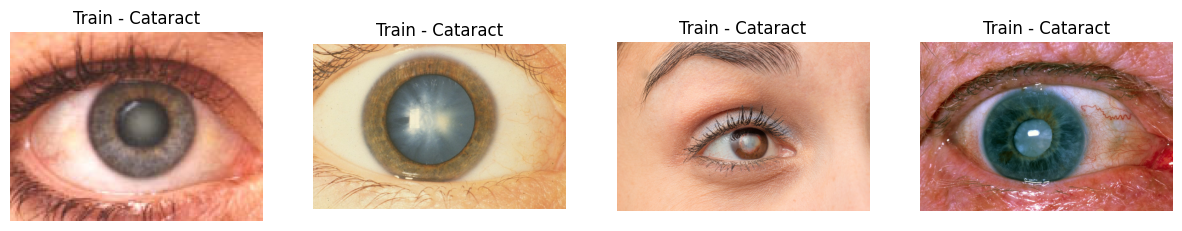

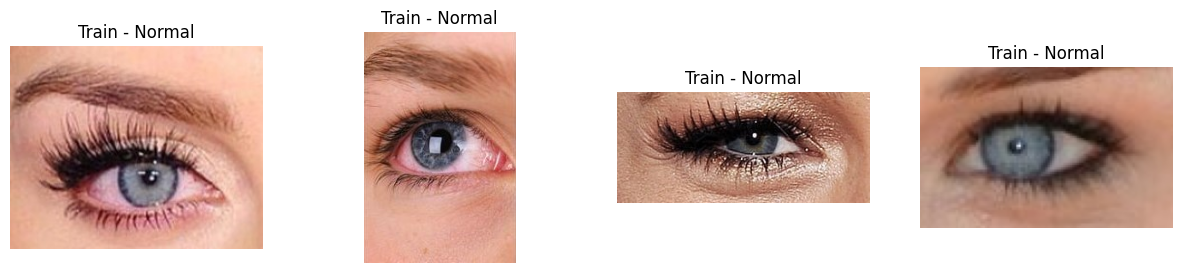

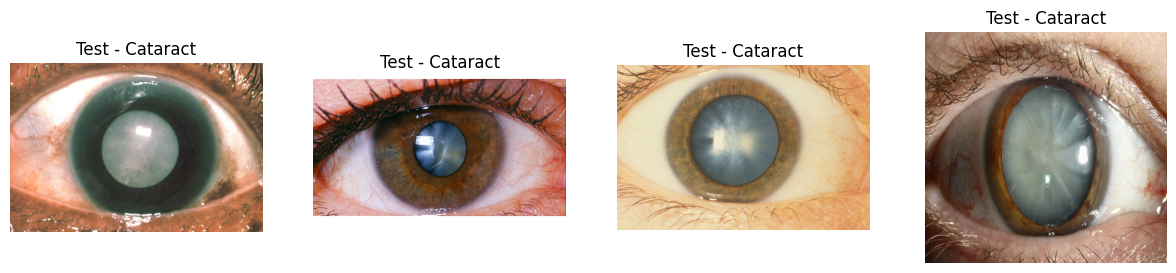

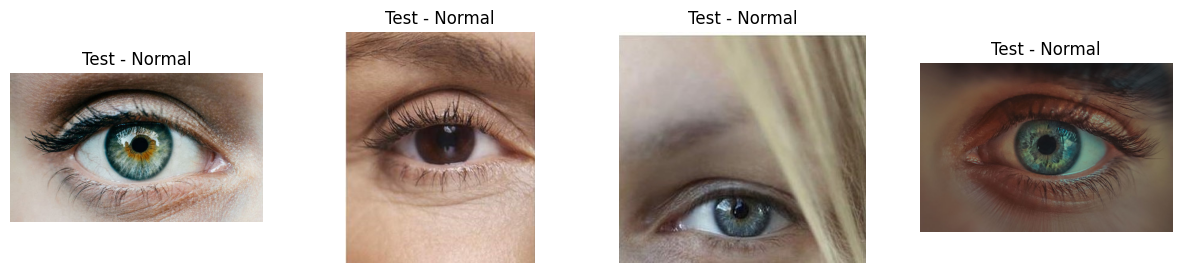

In [20]:

check_sample_images(train_cataract_dir, "Train - Cataract", 4)
check_sample_images(train_normal_dir, "Train - Normal", 4)


check_sample_images(test_cataract_dir, "Test - Cataract", 4)
check_sample_images(test_normal_dir, "Test - Normal", 4)

In [32]:
results = {}
for label, folder in {
    "train_cataract": train_cataract_dir,
    "train_normal": train_normal_dir,
    "test_cataract": test_cataract_dir,
    "test_normal": test_normal_dir
}.items():
    print(f"Checking: {label}")
    shapes = []
    for file in tqdm(glob(os.path.join(folder, "*.png"))):
        try:
            img = Image.open(file)
            shapes.append(img.size)
        except Exception as e:
            print(f"Corrupt: {file}")
    results[label] = Counter(shapes).most_common(3)
    print(results)

Checking: train_cataract


100%|██████████| 245/245 [00:02<00:00, 93.78it/s] 


{'train_cataract': [((1000, 667), 11), ((493, 335), 7), ((999, 650), 6)]}
Checking: train_normal


100%|██████████| 246/246 [00:02<00:00, 112.45it/s]


{'train_cataract': [((1000, 667), 11), ((493, 335), 7), ((999, 650), 6)], 'train_normal': [((852, 480), 4), ((157, 240), 3), ((1000, 587), 3)]}
Checking: test_cataract


100%|██████████| 61/61 [00:00<00:00, 179.53it/s]


{'train_cataract': [((1000, 667), 11), ((493, 335), 7), ((999, 650), 6)], 'train_normal': [((852, 480), 4), ((157, 240), 3), ((1000, 587), 3)], 'test_cataract': [((1200, 800), 3), ((1000, 667), 3), ((1091, 727), 3)]}
Checking: test_normal


100%|██████████| 60/60 [00:00<00:00, 178.94it/s]

{'train_cataract': [((1000, 667), 11), ((493, 335), 7), ((999, 650), 6)], 'train_normal': [((852, 480), 4), ((157, 240), 3), ((1000, 587), 3)], 'test_cataract': [((1200, 800), 3), ((1000, 667), 3), ((1091, 727), 3)], 'test_normal': [((590, 350), 1), ((312, 381), 1), ((312, 292), 1)]}


### Function to plot resolution distribution



In [47]:
def plot_resolution_distribution(directory, ax, title, top_k=5):
    sizes = []
    for fpath in glob(os.path.join(directory, "*.png")):
        with Image.open(fpath) as img:
            sizes.append(img.size)
    counter = Counter(sizes)
    most = counter.most_common(top_k)
    if not most:
        print(f"No images found in {directory}")
        return
    sizes, counts = zip(*most)
    labels = [f"{w}×{h}" for w,h in sizes]
    ax.bar(labels, counts)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

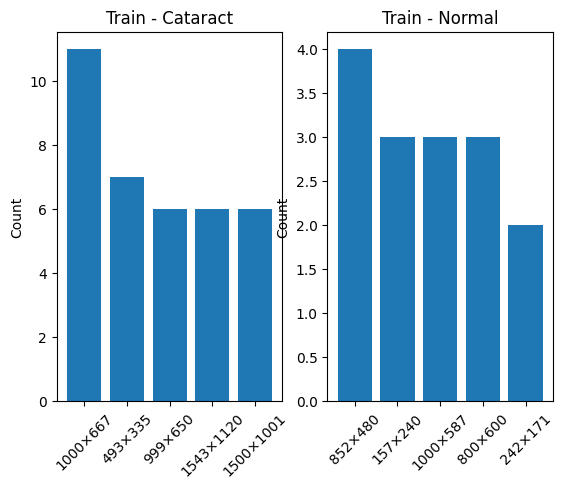

In [59]:
plot_resolution_distribution(train_cataract_dir, ax=plt.subplot(1, 2, 1), title="Train - Cataract")
plot_resolution_distribution(train_normal_dir, ax=plt.subplot(1, 2, 2), title="Train - Normal")

### Function to plot color histograms



In [52]:
def plot_color_histograms(directory, ax, title, sample_per_class=30):
    import random
    samples = []
    for cls in os.listdir(directory):
        cls_dir = os.path.join(directory, cls)
        if os.path.isdir(cls_dir):
            all_files = glob(os.path.join(cls_dir, "*.png"))
            samples += random.sample(all_files, min(sample_per_class, len(all_files)))

    if not samples:
        print(f"No images found in {directory}")
        return

    colors = ("r", "g", "b")
    for i, color in enumerate(colors):
        for f in samples[:5]:
            img = Image.open(f)
            arr = np.array(img)
            ax[i].hist(arr[..., i].flatten(), bins=50, alpha=0.5, label=os.path.basename(f))
            ax[i].set_title(f"{title} - {color.upper()} channel")
            ax[i].legend(fontsize="small")

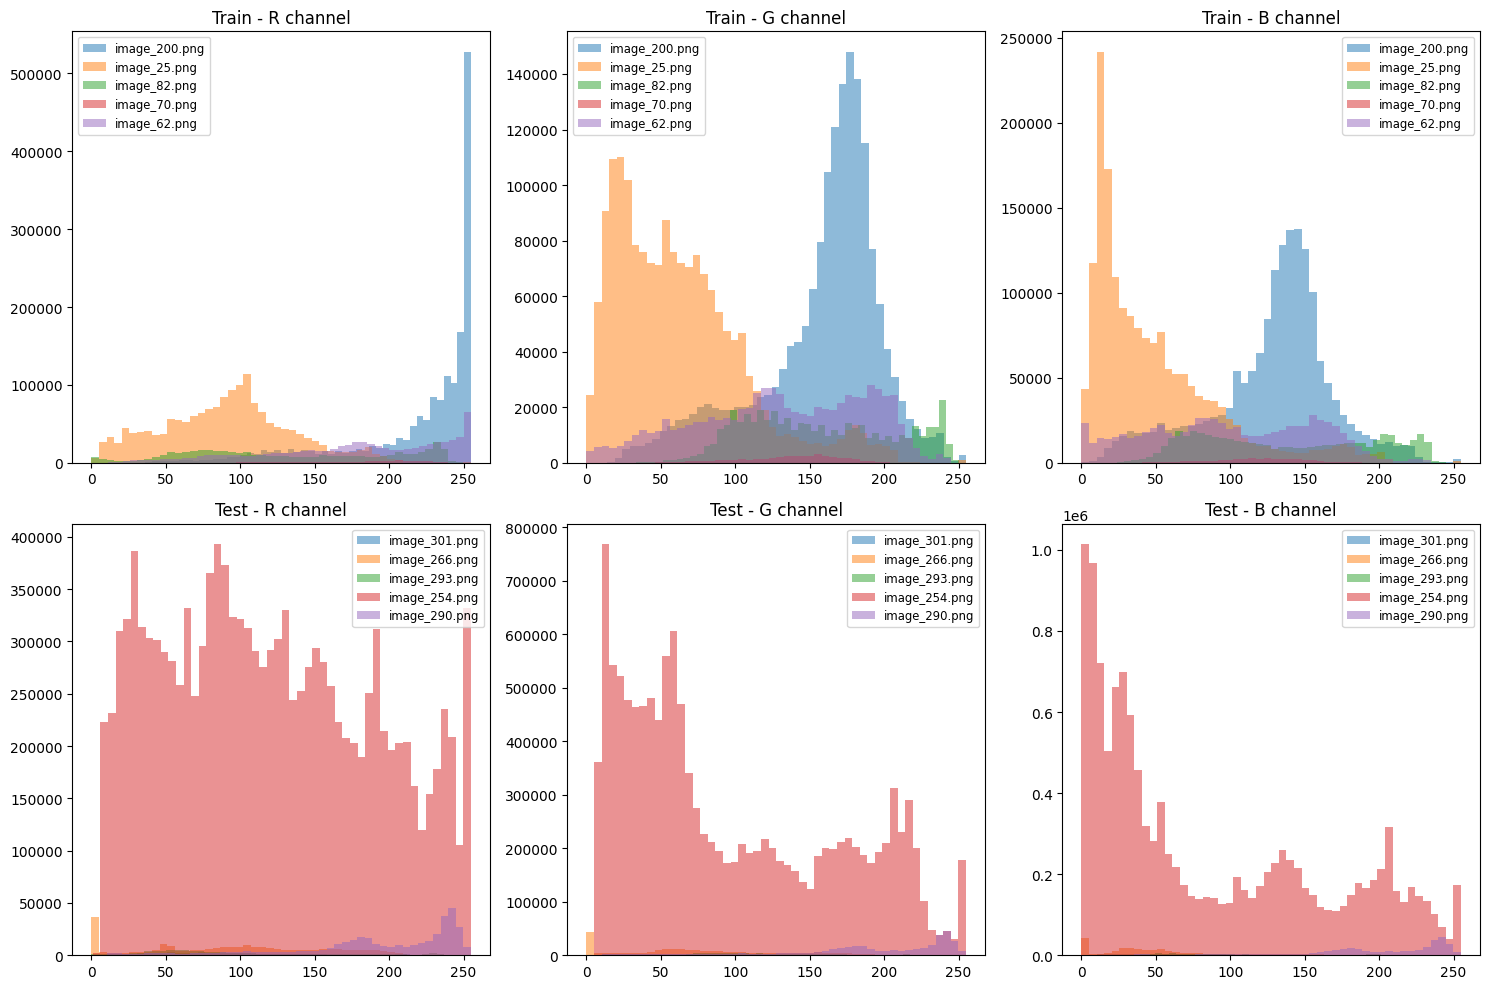

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_color_histograms(train_dir, axes[0], "Train")
plot_color_histograms(test_dir, axes[1], "Test")


plt.tight_layout()
plt.show()

### Function to deduplicate images



In [65]:
def deduplicate(root_dir, move_to="data/raw/duplicates"):
    seen_hashes = {}
    for fpath in glob(os.path.join(root_dir,"*.png")):
        with open(fpath, "rb") as f:
            h = hashlib.md5(f.read()).hexdigest()
        if h in seen_hashes:
            os.makedirs(move_to, exist_ok=True)
            cls = os.path.basename(os.path.dirname(fpath))
            dest = os.path.join(move_to, cls)
            os.makedirs(dest, exist_ok=True)
            shutil.move(fpath, dest)
            print(f"Duplicate: {fpath} (same as {seen_hashes[h]}) → {dest}")
        else:
            seen_hashes[h] = fpath

In [66]:
for split in ("train", "test"):
    split_root = f"data/raw/processed_images/{split}"
    deduplicate(split_root)
